In [1]:
import os
import logging
from typing import List, Optional
import wandb

import pandas as pd

import torch

from nll_to_po.models.dn_policy import MLPPolicy, MLPPolicyFullCov
from nll_to_po.training.utils import train_single_policy, setup_logger
import nll_to_po.training.loss as L
import nll_to_po.training.reward as R

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid", font_scale=1.5)
sns.set_palette("colorblind")
sns.despine()

logger = logging.getLogger("wandb")
logger.setLevel(logging.ERROR)
os.environ["WANDB_SILENT"] = "true"  # Suppress WandB output

<Figure size 640x480 with 0 Axes>

### config

In [2]:
mean = torch.zeros(2)
l= torch.tensor([[1.0, 0.0],
                  [0.5, 0.2]])  

dist = torch.distributions.MultivariateNormal(mean, scale_tril=l)

print("covariance:\n", dist.covariance_matrix)

covariance:
 tensor([[1.0000, 0.5000],
        [0.5000, 0.2900]])


In [3]:
df_list: list[pd.DataFrame] = []

In [4]:
def rand_sigma_tensor(output_dim):
    "renvoie une matrice de covariance aléatoire de taille output_dim fois output_dim"
    shape=(output_dim,output_dim)
    A=torch.rand(shape)
    matrix=A@A.T
    return matrix

(array([ 4476., 12926., 21387., 23416., 18901., 11514.,  5183.,  1749.,
          395.,    53.]),
 array([0.00602275, 0.37881333, 0.7516039 , 1.12439442, 1.49718499,
        1.86997557, 2.24276614, 2.61555672, 2.98834729, 3.36113787,
        3.73392844]),
 <BarContainer object of 10 artists>)

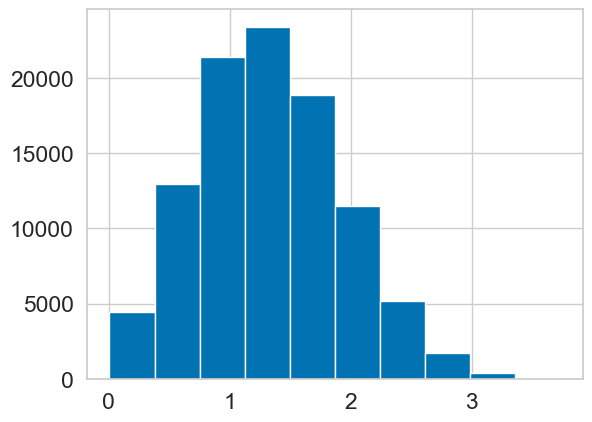

In [5]:
Trace=[]
for k in range(int(1e5)):
    A=rand_sigma_tensor(2)
    Trace.append(torch.trace(A))
plt.hist(Trace)

EXP avec beta etoile d'apres les calculs 

In [5]:
import torch
from torch.distributions import MultivariateNormal
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

torch.manual_seed(0)
output_dim = 2

# RL/PO params
n_generations = 300
use_rsample = False
reward_transform = "normalize"
entropy_weight = 1e-4
# training params
n_experiments = 50
n_updates = 100
learning_rate = 1*1e-3
input_dim = 10
number_of_hidden_layers=4
hidden_sizes = [256]*number_of_hidden_layers
fixed_logstd = False # Pour que le NN apprennne aussi la matrice de covariance 

df_list = []

for exp_idx in range(n_experiments):
    torch.manual_seed(1234 + exp_idx)

    mu = torch.ones(output_dim)
    Sigma=rand_sigma_tensor(output_dim=output_dim)
   
    q = MultivariateNormal(mu, covariance_matrix=Sigma)

    N = 128
    y = q.sample((N,))                          # (N,2)
    X = torch.randn(1, input_dim).repeat(N, 1)  # X constant (jouet)
    batch_size = N

    train_dataset = torch.utils.data.TensorDataset(X, y)
    train_dataloader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True
    )

    policy = MLPPolicyFullCov(input_dim, output_dim, hidden_sizes)

    loss_nll = L.NLL(target_mu=mu, 
        target_sigma=Sigma)
    _, nll_metrics, _ = train_single_policy(
        policy=policy,
        train_dataloader=train_dataloader,
        loss_function=loss_nll,
        n_updates=n_updates,
        learning_rate=learning_rate,
        wandb_run=None,
        tensorboard_writer=None,
        logger=None,
    )

    df = pd.DataFrame(nll_metrics).reset_index().rename(columns={"index": "epoch"})
    df["method"] = "NLL"
    df["beta"] = None
    df["is_special"] = False
    df["experiment"] = exp_idx
    # log mu, Sigma (scalaires)
    df["mu_0"] = float(mu[0]); df["mu_1"] = float(mu[1])
    df["Sigma_00"] = float(Sigma[0,0]); df["Sigma_01"] = float(Sigma[0,1])
    df["Sigma_10"] = float(Sigma[1,0]); df["Sigma_11"] = float(Sigma[1,1])
    df["entropy_weight"] = entropy_weight
    df_list.append(df)

    #Policy Gradient avec le U etoile trouve en closed form 
    Sigma_trace = float(torch.trace(Sigma))
    beta_star = float(entropy_weight / Sigma_trace)  # U* dans F_lambda,Sigma
    betas = [1,beta_star]

    for beta in betas:
        policy = MLPPolicyFullCov(input_dim, output_dim, hidden_sizes)

        U = beta * torch.eye(output_dim)
        reward_fn = R.Mahalanobis(matrix=U)

        loss_po = L.PO_Entropy(
            reward_fn=reward_fn,
            n_generations=n_generations,
            use_rsample=use_rsample,
            reward_transform=reward_transform,
            entropy_weight=entropy_weight,
            target_mu=mu, 
        target_sigma=Sigma,
        )

        _, po_metrics, _ = train_single_policy(
            policy=policy,
            train_dataloader=train_dataloader,
            loss_function=loss_po,
            n_updates=n_updates,
            learning_rate=learning_rate,
            wandb_run=None,
            tensorboard_writer=None,
            logger=None,
        )

        df = pd.DataFrame(po_metrics).reset_index().rename(columns={"index": "epoch"})
        df["method"] = "Policy_Gradient_Entropy"
        df["beta"] = beta
        df["is_special"] = abs(beta - beta_star) < 1e-12
        df["experiment"] = exp_idx
        df["mu_0"] = float(mu[0]); df["mu_1"] = float(mu[1])
        df["Sigma_00"] = float(Sigma[0,0]); df["Sigma_01"] = float(Sigma[0,1])
        df["Sigma_10"] = float(Sigma[1,0]); df["Sigma_11"] = float(Sigma[1,1])
        df["entropy_weight"] = entropy_weight
        df_list.append(df)



Training epochs: 100%|██████████| 100/100 [00:00<00:00, 206.28it/s]


/var/folders/s5/t7mmwbn97js0q3cx70zrm69c0000gp/T/ipykernel_40786/763344390.py:1: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_all = pd.concat(df_list, ignore_index=True)
/var/folders/s5/t7mmwbn97js0q3cx70zrm69c0000gp/T/ipykernel_40786/763344390.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  others["U_label"] = others["beta"].map(lambda b: f"(U={b:g}·I)")
/var/folders/s5/t7mmwbn97js0q3cx70zrm69c0000gp/T/ipykernel_40786/763344390.py:36: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from f

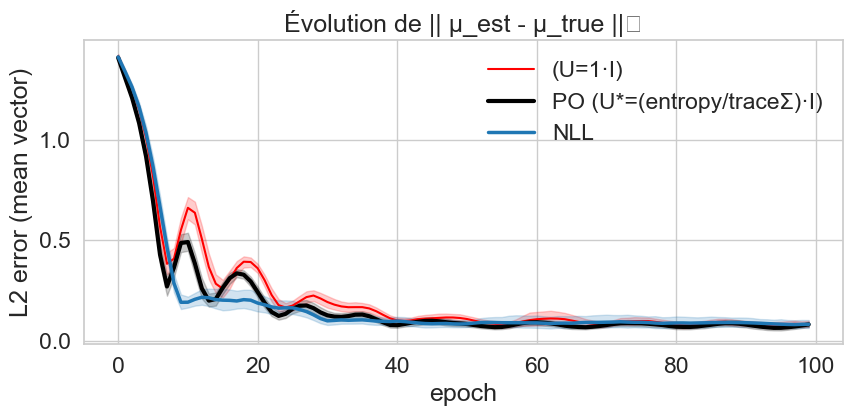

In [7]:
df_all = pd.concat(df_list, ignore_index=True)

sns.set_style("whitegrid")
fig, ax = plt.subplots(1, 1, figsize=(9, 4.5))

# Policy Gradient (U ≠ U*) en couleurs
others = df_all[(df_all["method"] == "Policy_Gradient_Entropy") & (~df_all["is_special"])]
if not others.empty:
    others["U_label"] = others["beta"].map(lambda b: f"(U={b:g}·I)")
    sns.lineplot(
        data=others, x="epoch", y="L2_error",
        hue="U_label", errorbar=("ci", 95), ax=ax, legend=True,  palette=["red"] * others["U_label"].nunique()
    )

# PO_Entropy pour U* en noir
special = df_all[(df_all["method"] == "Policy_Gradient_Entropy") & (df_all["is_special"])]
if not special.empty:
    sns.lineplot(
        data=special, x="epoch", y="L2_error",
        errorbar=("ci", 95), ax=ax, color="black", linewidth=3,
        label=r"PO (U*=(entropy/traceΣ)·I)"
    )

# Ligne NLL baseline
base = df_all[df_all["method"] == "NLL"]
sns.lineplot(
    data=base, x="epoch", y="L2_error",
    errorbar=("ci", 95), ax=ax, color="#1f77b4", linewidth=2.5, label="NLL"
)

ax.set_title("Évolution de || μ_est - μ_true ||₂")
ax.set_ylabel("L2 error (mean vector)")
ax.set_xlabel("epoch")
ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
ax.legend(loc="best", frameon=False)
plt.tight_layout()
plt.show()


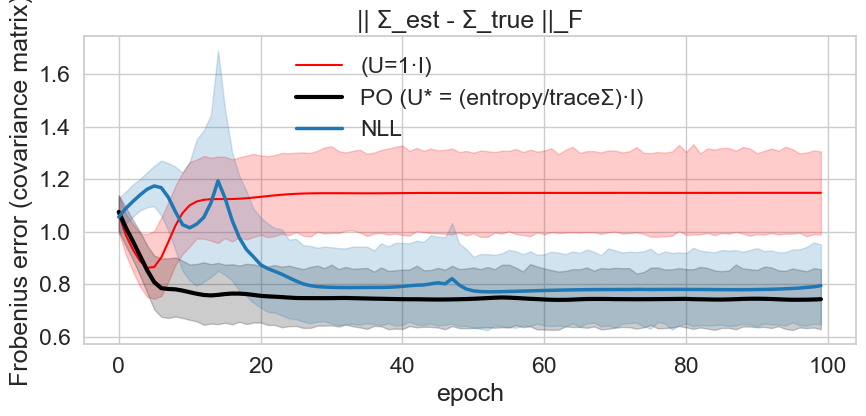

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(9, 4.5))

# Policy Gradient (U ≠ U*) en rouge
others = df_all[(df_all["method"] == "Policy_Gradient_Entropy") & (~df_all["is_special"])]
if not others.empty:
    others = others.copy()  # éviter le warning pandas
    others["U_label"] = others["beta"].map(lambda b: f"(U={b:g}·I)")
    sns.lineplot(
        data=others, x="epoch", y="std_error",
        hue="U_label", errorbar=("ci", 95), ax=ax, legend=True,
        palette=["red"] * others["U_label"].nunique()
    )

# Policy Gradient (U*) en noir épais
special = df_all[(df_all["method"] == "Policy_Gradient_Entropy") & (df_all["is_special"])]
if not special.empty:
    sns.lineplot(
        data=special, x="epoch", y="std_error",
        errorbar=("ci", 95), ax=ax, color="black", linewidth=3,
        label=r"PO (U* = (entropy/traceΣ)·I)"
    )

# NLL baseline en bleu
base = df_all[df_all["method"] == "NLL"]
sns.lineplot(
    data=base, x="epoch", y="std_error",
    errorbar=("ci", 95), ax=ax, color="#1f77b4", linewidth=2.5, label="NLL"
)

ax.set_title("|| Σ_est - Σ_true ||_F")
ax.set_ylabel("Frobenius error (covariance matrix)")
ax.set_xlabel("epoch")
ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
ax.legend(loc="best", frameon=False)
plt.tight_layout()
plt.show()


/var/folders/s5/t7mmwbn97js0q3cx70zrm69c0000gp/T/ipykernel_38373/1396781808.py:1: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_all = pd.concat(df_list, ignore_index=True)


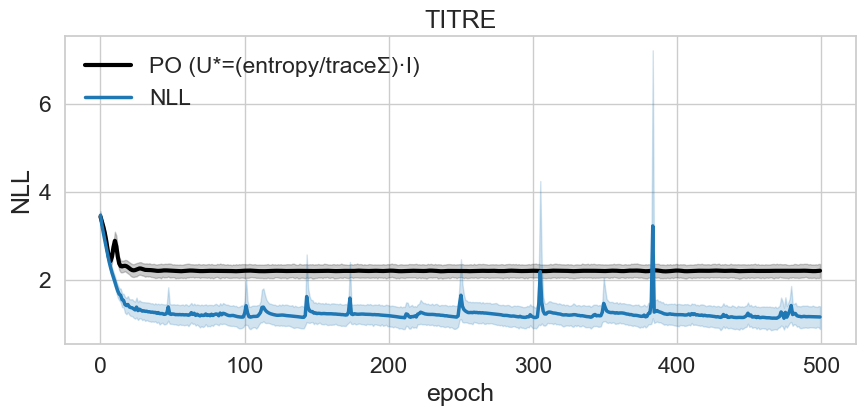

In [46]:
df_all = pd.concat(df_list, ignore_index=True)

sns.set_style("whitegrid")
fig, ax = plt.subplots(1, 1, figsize=(9, 4.5))

others = df_all[(df_all["method"] == "Policy_Gradient_Entropy") & (~df_all["is_special"])]
if not others.empty:
    others["U_label"] = others["beta"].map(lambda b: f"(U={b:g}·I)")
    sns.lineplot(
        data=others, x="epoch", y="NLL",
        hue="U_label", errorbar=("ci", 95), ax=ax, legend=True
    )

# PO_Entropy pour U* en noir épais
special = df_all[(df_all["method"] == "Policy_Gradient_Entropy") & (df_all["is_special"])]
if not special.empty:
    sns.lineplot(
        data=special, x="epoch", y="NLL",
        errorbar=("ci", 95), ax=ax, color="black", linewidth=3, label=r"PO (U*=(entropy/traceΣ)·I)"
    )

# Ligne NLL baseline
base = df_all[df_all["method"] == "NLL"]
sns.lineplot(
    data=base, x="epoch", y="NLL",
    errorbar=("ci", 95), ax=ax, color="#1f77b4", linewidth=2.5, label="NLL"
)

ax.set_title("TITRE")
ax.set_ylabel("NLL")
ax.set_xlabel("epoch")
ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
ax.legend(loc="best", frameon=False)
plt.tight_layout()
plt.show()


### ablations

In [13]:
def plot_ablation(
    df: pd.DataFrame,
    hue_variable: str,
    style_variable: Optional[str] = None,
    loss_type_list: List[str] = [],
    use_rsample_list: List[bool] = [],
    n_generations_list: List[int] = [],
    entropy_weight_list: List[float] = [],
    reward_transform_list: List[str] = [],
):
    sub_df = df.copy()
    if loss_type_list:
        sub_df = sub_df[sub_df["loss_type"].isin(loss_type_list)]
    if use_rsample_list:
        sub_df = sub_df[sub_df["use_rsample"].isin(use_rsample_list)]
    if n_generations_list:
        sub_df = sub_df[sub_df["n_generations"].isin(n_generations_list)]
    if entropy_weight_list:
        sub_df = sub_df[sub_df["entropy_weight"].isin(entropy_weight_list)]
    if reward_transform_list:
        sub_df = sub_df[sub_df["reward_transform"].isin(reward_transform_list)]

    _, ax = plt.subplots(1, 4, figsize=(16, 5))
    for i, metric in enumerate(["loss", "NLL"]):
        sns.lineplot(
            data=sub_df,
            x="epoch",
            y=metric,
            hue=hue_variable,
            style=style_variable,
            ax=ax[i],
            legend=False if i > 0 else True,
        )
        ax[i].set_ylabel(None)
        ax[i].set_title(metric)
        ax[i].ticklabel_format(axis="y", style="sci", scilimits=(0, 1))
    ax[0].legend(bbox_to_anchor=(2.5, -0.35), loc="lower center", ncol=4, frameon=False)
    plt.show()

In [5]:
import torch
from torch.distributions import MultivariateNormal
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# ----------------------- config -----------------------
torch.manual_seed(0)
output_dim = 2

# RL/PO params
n_generations = 300
use_rsample = False
reward_transform = "normalize"
entropy_weight = 1e-4

# training params
n_experiments = 50
n_updates = 500
input_dim = 10
number_of_hidden_layers = 4
hidden_sizes = [256] * number_of_hidden_layers

learning_rates = [1e-5, 3e-5, 1e-4, 3e-4, 1e-3, 3e-3, 1e-2, 3e-2, 1e-1]


df_list = []

for exp_idx in range(n_experiments):
    # seed par expérience (pour comparabilité entre LRs)
    torch.manual_seed(1234 + exp_idx)

    # --------- données fixes pour TOUTES les LRs de CETTE expérience ---------
    mu = torch.ones(output_dim)
    Sigma = rand_sigma_tensor(output_dim=output_dim)  # ta fonction
    q = MultivariateNormal(mu, covariance_matrix=Sigma)

    N = 128
    y = q.sample((N,))                          # (N, D)
    X = torch.randn(1, input_dim).repeat(N, 1)  # X constant (jouet)
    batch_size = N

    train_dataset = torch.utils.data.TensorDataset(X, y)
    train_dataloader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True
    )

    # U* pour cette expérience (dépend de Sigma uniquement)
    Sigma_trace = float(torch.trace(Sigma))
    beta_star = float(entropy_weight / Sigma_trace)

    for lr in learning_rates:
        # -------------------- NLL baseline --------------------
        policy = MLPPolicyFullCov(input_dim, output_dim, hidden_sizes)
        loss_nll = L.NLL()
        _, nll_metrics, _ = train_single_policy(
            policy=policy,
            train_dataloader=train_dataloader,
            loss_function=loss_nll,
            n_updates=n_updates,
            learning_rate=lr,                 # <--- LR variable
            wandb_run=None,
            tensorboard_writer=None,
            logger=None,
        )
        df = (
            pd.DataFrame(nll_metrics)
            .reset_index()
            .rename(columns={"index": "epoch"})
        )
        df["method"] = "NLL"
        df["beta"] = None
        df["is_special"] = False
        df["experiment"] = exp_idx
        df["lr"] = lr
        df["mu_0"] = float(mu[0]); df["mu_1"] = float(mu[1])
        df["Sigma_00"] = float(Sigma[0,0]); df["Sigma_01"] = float(Sigma[0,1])
        df["Sigma_10"] = float(Sigma[1,0]); df["Sigma_11"] = float(Sigma[1,1])
        df["entropy_weight"] = entropy_weight
        df_list.append(df)

        # -------------------- PO_Entropy with U* --------------------
        policy = MLPPolicyFullCov(input_dim, output_dim, hidden_sizes)

        U = beta_star * torch.eye(output_dim)
        reward_fn = R.Mahalanobis(matrix=U)
        loss_po = L.PO_Entropy(
            reward_fn=reward_fn,
            n_generations=n_generations,
            use_rsample=use_rsample,
            reward_transform=reward_transform,
            entropy_weight=entropy_weight,
        )

        _, po_metrics, _ = train_single_policy(
            policy=policy,
            train_dataloader=train_dataloader,
            loss_function=loss_po,
            n_updates=n_updates,
            learning_rate=lr,                 # <--- même LR que la NLL
            wandb_run=None,
            tensorboard_writer=None,
            logger=None,
        )
        df = (
            pd.DataFrame(po_metrics)
            .reset_index()
            .rename(columns={"index": "epoch"})
        )
        df["method"] = "PO_Entropy"
        df["beta"] = beta_star
        df["is_special"] = True
        df["experiment"] = exp_idx
        df["lr"] = lr
        df["mu_0"] = float(mu[0]); df["mu_1"] = float(mu[1])
        df["Sigma_00"] = float(Sigma[0,0]); df["Sigma_01"] = float(Sigma[0,1])
        df["Sigma_10"] = float(Sigma[1,0]); df["Sigma_11"] = float(Sigma[1,1])
        df["entropy_weight"] = entropy_weight
        df_list.append(df)

# ----------------------- concat -----------------------
df_all = pd.concat(df_list, ignore_index=True)

# ----------------------- plots -----------------------
sns.set_style("whitegrid")

# Un panneau par LR
g = sns.FacetGrid(
    df_all, col="lr", col_wrap=2, sharey=False, height=3.6, aspect=1.4
)

def _panel(data, color, **kwargs):
    # PO (U*) en noir épais
    special = data[(data["method"] == "PO_Entropy") & (data["is_special"])]
    if not special.empty:
        sns.lineplot(
            data=special, x="epoch", y="NLL",
            errorbar=("ci", 95), color="black", linewidth=2.5, label=r"PO (U*)", **kwargs
        )
    # NLL baseline
    base = data[data["method"] == "NLL"]
    sns.lineplot(
        data=base, x="epoch", y="NLL",
        errorbar=("ci", 95), linewidth=2.0, label="NLL", **kwargs
    )

g.map_dataframe(_panel)
g.set_axis_labels("epoch", "NLL")
g.set_titles(col_template="lr = {col_name:g}")
for ax in g.axes.flatten():
    ax.legend(loc="best", frameon=False)
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
plt.tight_layout()
plt.show()


Training epochs:   0%|          | 2/500 [00:00<00:02, 222.52it/s]


ValueError: Expected parameter loc (Tensor of shape (128, 2)) of distribution MultivariateNormal(loc: torch.Size([128, 2]), scale_tril: torch.Size([128, 2, 2])) to satisfy the constraint IndependentConstraint(Real(), 1), but found invalid values:
tensor([[nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan]], grad_fn=<ExpandBackward0>)